<a href="https://colab.research.google.com/github/aishstronomer/flare-finder/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set globals

# do Google Colab things
try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    IN_COLAB = True
except:
    IN_COLAB = False

# install dependencies
path_to_coderepo = (
    "/content/drive/MyDrive/ML_project/code_repo/flare-finder" if IN_COLAB else "."
)
if IN_COLAB:
    !pip install -r {path_to_coderepo}/requirements.txt

# import standard libraries
from IPython.display import clear_output
import glob
import matplotlib.pyplot as plt
import pandas as pd
import sys

# import custom libraries
if f'{path_to_coderepo}/src' not in sys.path:
    sys.path.append(f'{path_to_coderepo}/src')
from goes_file_parser import GOESFileParser
from sdo_image_fetcher import SDOImageFetcher
from solar_image_flare_labels import SDOImageFlareTagging

In [2]:
# save 2015 GOES events to csv

directory_path = f"{path_to_coderepo}/../../2015_events"
df = GOESFileParser.get_goes_events_df_for_interval(
    directory_path, "20150101", "20151231"
)
df.to_csv(f"{path_to_coderepo}/goes_events_clean_2015.csv", index=False)
print("goes_events_clean_2015.csv content =")
pd.read_csv(f"{path_to_coderepo}/goes_events_clean_2015.csv")

goes_events_clean_2015.csv content =


,Event,Obs,Q,Type,Loc/Freq,Particulars_a,begin_datetime,max_datetime,end_datetime
0,3690,LEA,3,FLA,S08E54,SF,2015-01-01 01:38:00,2015-01-01 01:39:00,2015-01-01 01:41:00
1,3700,LEA,3,FLA,S08E54,SF,2015-01-01 02:25:00,2015-01-01 02:27:00,2015-01-01 02:29:00
2,3710,LEA,3,FLA,S08E54,SF,2015-01-01 03:16:00,2015-01-01 03:16:00,2015-01-01 03:20:00
3,3720,LEA,3,FLA,S08E54,SF,2015-01-01 03:40:00,2015-01-01 03:41:00,2015-01-01 03:44:00
4,3730,LEA,C,RSP,109-171,CTM/1,2015-01-01 03:51:00,NaN,2015-01-01 04:17:00
...,...,...,...,...,...,...,...,...,...
9409,9930,LEA,1,FLA,N08E57,SF,NaN,NaN,NaN
9410,9940,HOL,2,DSF,N17W24,4,NaN,NaN,NaN
9411,9980,LEA,2,EPL,////,0.26,NaN,NaN,NaN
9412,9980,SVI,3,FLA,S23W52,1F,NaN,NaN,NaN


Total solar images available = 8550
single image_path = ./../../data/sdo_images/2015-01-08 07:00:12.340000+00:00.png


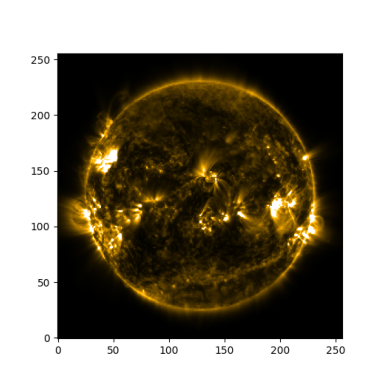

In [3]:
# fetch the solar images
# - can take long depending on connection
# - code is fault tolerant; if connection is lost, it will resume from where it left off

# common variables
s3_root_for_sdoml_year_zarr = (
    "s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/2015/"
)
sav_folder_path = f"{path_to_coderepo}/../../data/sdo_images"

# fetch solar images for year 2015 for every hour-start
desired_times = pd.date_range(
    start="2015-01-01 00:00:00", end="2015-12-31 23:59:59", freq="60T", tz="UTC"
)
solar_imgs_fetched_paths = SDOImageFetcher.get_sdo_solar_images_from_aws(
    s3_root_for_sdoml_year_zarr,
    desired_times,
    sav_folder_path,
    tolerance=pd.Timedelta(days=1000),
    is_verbose=True,
)

# fetch solar images for Goes big flare events for year 2015
# - Big flare means M/X class flare
# - We specify a 10 min tolerance for the flare event time
goes_events_data = pd.read_csv(f"{path_to_coderepo}/goes_events_clean_2015.csv")
goes_MX_events = goes_events_data[
    goes_events_data["Particulars_a"].str.lower().str.startswith(("m", "x"))
]
goes_MX_event_times = pd.to_datetime(
    goes_MX_events["max_datetime"].fillna(goes_MX_events["begin_datetime"]), utc=True
).tolist()
solar_bigflr_imgs_fetched_paths = SDOImageFetcher.get_sdo_solar_images_from_aws(
    s3_root_for_sdoml_year_zarr,
    goes_MX_event_times,
    sav_folder_path,
    tolerance=pd.Timedelta(minutes=10),
    is_verbose=True,
)

# clear console and print download stats
clear_output()
print(f"Solar images downloaded this run = {len(solar_imgs_fetched_paths) + len(solar_bigflr_imgs_fetched_paths)}")
print(f"Total solar images available = {len(glob.glob(sav_folder_path + '/*.png'))}")

# display a fetched solar image
%matplotlib inline
image_path = glob.glob(sav_folder_path + "/*.png")[0]
print(f"single image_path = {image_path}" )
plt.axis("off")
plt.imshow(plt.imread(image_path))

value counts for is_big_flare = 
is_big_flare
0       6109
None    2323
1        118
Name: count, dtype: int64

some not-big-flares


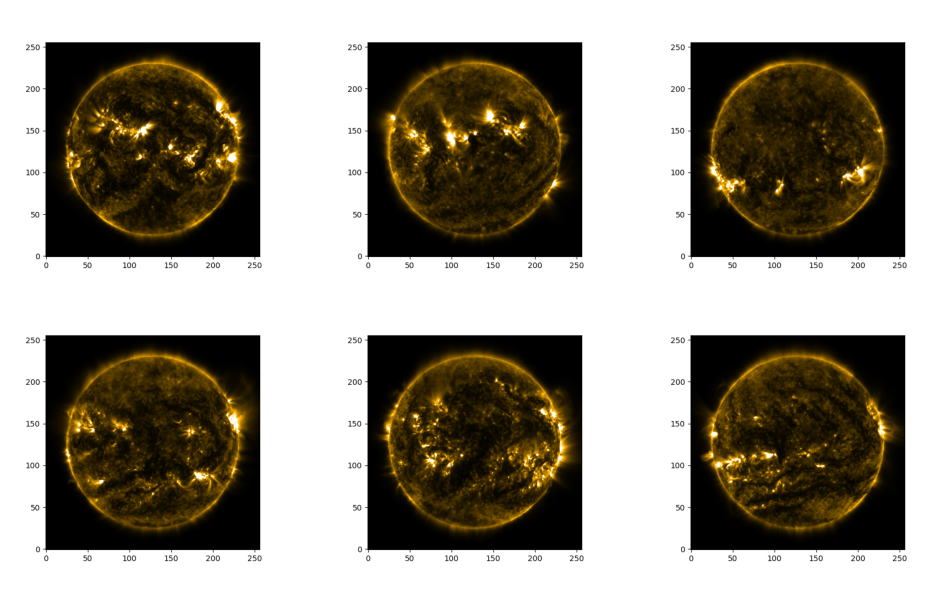

some big-flares


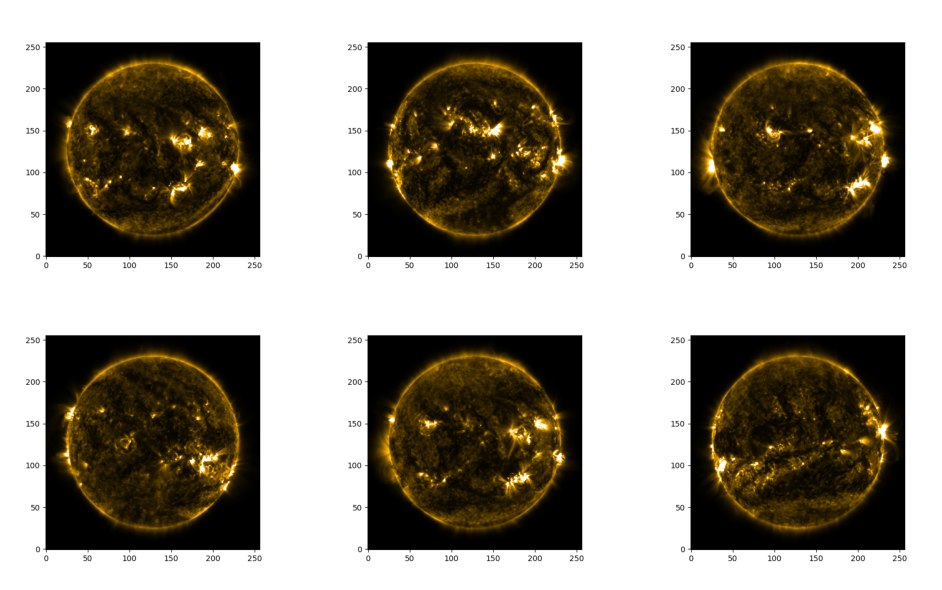

In [4]:
# generate target labels for the solar images and save to csv

# get big flare labels
goes_file_path = f"{path_to_coderepo}/goes_events_clean_2015.csv"
solar_images_folder = f"{path_to_coderepo}/../../data/sdo_images"
big_flare_labels_df = SDOImageFlareTagging.get_big_flare_labels(
    solar_images_folder, goes_file_path
)
big_flare_labels_df.to_csv(f"{path_to_coderepo}/big_flare_labels.csv", index=False)
print(f"value counts for is_big_flare = ")
print(big_flare_labels_df["is_big_flare"].value_counts(dropna=False))

# plot some not-big-flares
print("\nsome not-big-flares")
plot_df = big_flare_labels_df[big_flare_labels_df["is_big_flare"] == 0].sample(
    6, random_state=0
)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
SDOImageFlareTagging.plot_solar_images(solar_images_folder, plot_df, axs)

# plot some big-flares
print("some big-flares")
plot_df = big_flare_labels_df[big_flare_labels_df["is_big_flare"] == 1].sample(
    6, random_state=0
)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
SDOImageFlareTagging.plot_solar_images(solar_images_folder, plot_df, axs)